In [126]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

In [127]:
#importando base já tratada
dados = pd.read_json('dados_notas_col.json')
print(dados.id.nunique())
print(dados.shape)
dados.head(3)

6395
(6395, 34)


,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaII90H,MatemticaI120H,MatemticaII90H,ano_letivo__ano,ano_letivo__ano_matricula_periodo,cep,classe,data,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_encaminhamento,descricao_historico,descricao_historico_disciplina,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_situacao_matricula_periodo,descricao_trabalho_responsavel,id,media_final,nome_escola_ensino_fundamental,percentual_frequencia,pessoa_fisica__nascimento_data,pessoa_fisica__sexo,professores,qnt_pc,qtd_pessoas_domicilio,renda_bruta_familiar,sigla
0,86,-1,87,-1,2016,2016,59067-400,1,05/05/2017,Matriculado,Urbana,Pais,Diálogo com professor(a),Técnico de Nível Médio em Edificações,Língua Portuguesa e Literatura I(90H),Financiado,Pós graduação incompleto,Pós graduação completo,Parda,Pós graduação completo,Pai,Aprovado,Serviço público,496915657473,86,Complexo Educacional Contemporâneo,85.0,06/12/2001,M,[1521],NaN,4,9000.0,CNAT
100002,69,-1,5,-1,2015,2016,59795-000,1,None,Matriculado,Urbana,Mãe,None,"Técnico de Nivel Médio em Agropecuária, na For...",Língua Portuguesa e Literatura I(90H),Alugado,Ensino fundamental incompleto,Ensino médio completo,Branca,Ensino médio completo,Pai,Dependência,Autônomo,458905053917,69,Escola Estadual António Francisco,92.0,16/12/1999,M,"[2688, 3538, 1222]",0.0,3,500.0,AP
100021,83,-1,77,-1,2016,2016,59200-000,1,None,Matriculado,Urbana,Pais,None,Técnico de Nivel Médio Informática,Língua Portuguesa e Literatura I(90H),Alugado,Ensino médio completo,Ensino médio incompleto,Branca,Ensino médio completo,Pai,Aprovado,Autônomo,496533683389,83,IESC,99.0,01/06/2000,F,"[1592, 3388]",0.0,7,2500.0,SC


In [128]:
#removendo colunas que explodem a quantidade de atributos quando binarizados
del dados['descricao_historico_disciplina']
del dados['professores']
del dados['id']
del dados['media_final']
del dados['percentual_frequencia']
del dados['nome_escola_ensino_fundamental']
del dados['qnt_pc']

#tentar colocar novamente
del dados['cep']
del dados['data']
del dados['pessoa_fisica__nascimento_data']

#descricao_encaminhamento colocar booleano
 
#dados que fazem a indicação se o aluno foi evadido ou não
del dados['descricao']
del dados['descricao_situacao_matricula_periodo']

In [129]:
#configura os dados de entrada e saída
y = dados.classe
X = dados

del X['classe']
X.shape

(6395, 21)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


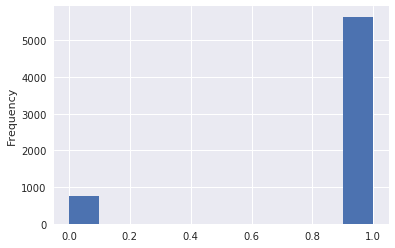

In [101]:
#visualizacao de dados
y.plot.hist()

In [130]:
#binazira os dados devido aos atributos categoricos 
dados_dummies = pd.get_dummies(X, drop_first=False)
dados_dummies.shape

(6395, 161)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


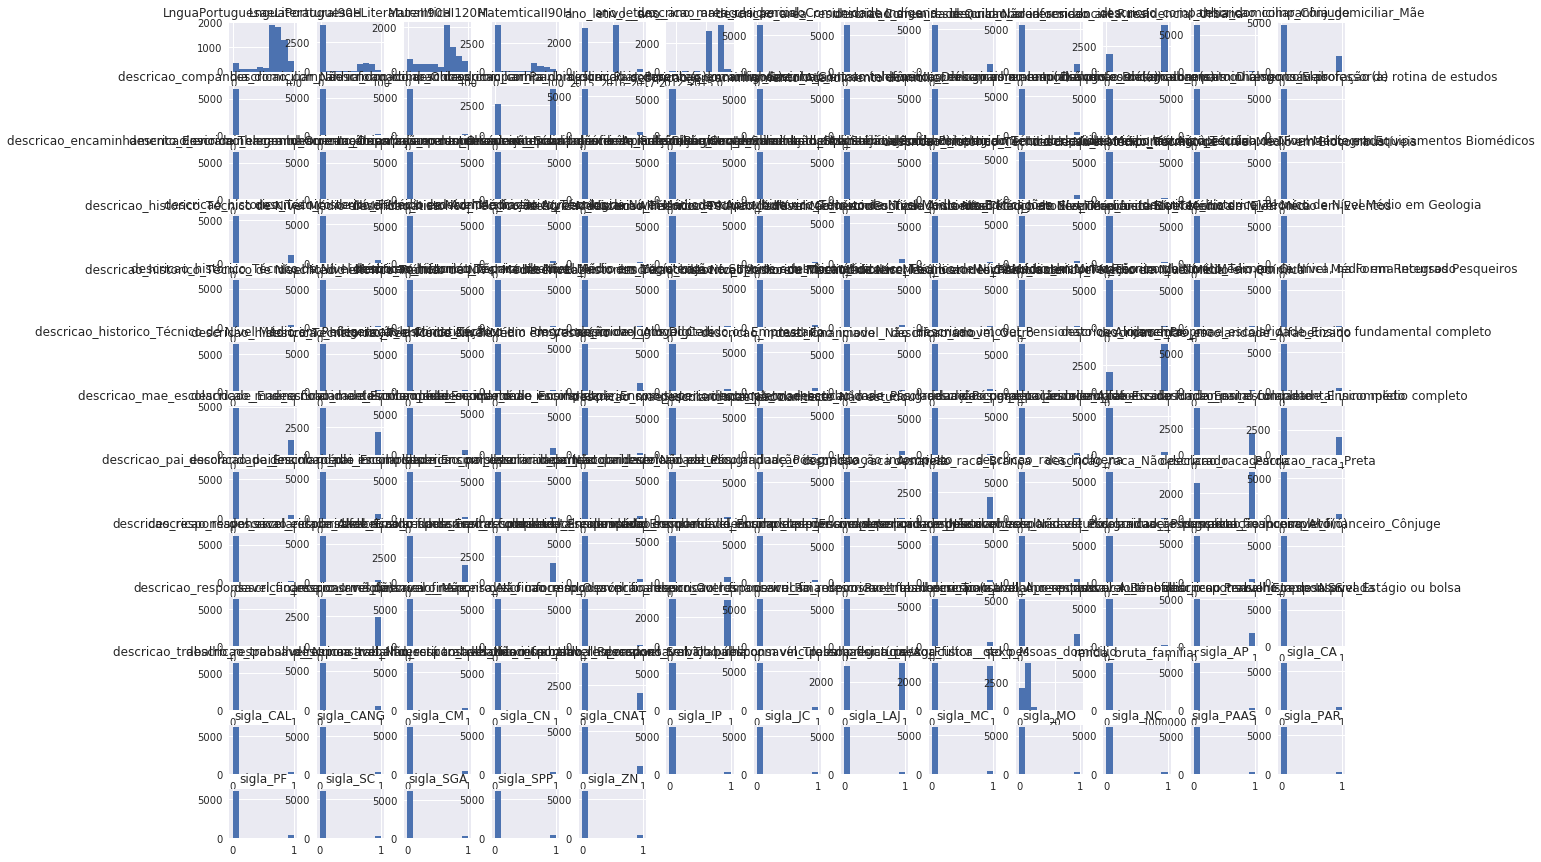

In [122]:
%matplotlib inline
dados_dummies.hist(figsize=(20, 15))
plt.show()

In [103]:
#remove atributos inconistentes
#dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
#dados_clean = dados_clean.dropna(axis=1, how='all')
#dados_clean.info()

In [88]:
#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#nao houve diferenças visivelmente

#dados_clean = StandardScaler().fit_transform(dados_clean) 
#dados_clean = MinMaxScaler().fit_transform(dados_clean) 
#dados_clean = RobustScaler(quantile_range=(25, 75)).fit_transform(dados_clean) 

In [ ]:
#SELECIONANDO MELHOR MODEL RF
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint

"""
param_grid = [    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},    
                  {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},  ]

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

forest_reg = RandomForestClassifier()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,                           
                           scoring='neg_mean_squared_error')
"""

#cria a randomforest 
forest_reg = RandomForestClassifier(n_jobs=-1, max_features='sqrt' , n_estimators=50, oob_score=True) 

param_dist = {"max_depth": [3, None],
              'max_features': ['auto', 'sqrt', 'log2'],
              'n_estimators': [200, 700],
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)

#caso queira estratificar os dados
#StratifiedShuffleSplit

#seleciona o melhor modelo de acordo com os parâmetros
grid_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid, cv = 5)
grid_search.fit(Xtrain, ytrain)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

In [125]:
#cvres = grid_search.cv_results_ 
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]): 
#    print(np.sqrt(-mean_score), params) 
    
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.924 (std: 0.007)
Parameters: {'max_features': 'sqrt', 'n_estimators': 700}

Model with rank: 2
Mean validation score: 0.924 (std: 0.006)
Parameters: {'max_features': 'auto', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.924 (std: 0.008)
Parameters: {'max_features': 'auto', 'n_estimators': 700}

Model with rank: 2
Mean validation score: 0.924 (std: 0.007)
Parameters: {'max_features': 'sqrt', 'n_estimators': 200}



In [116]:
#RANDOM FOREST
"""
from sklearn.cross_validation import train_test_split

#cria e treina o modelo
Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)
model = RandomForestClassifier(n_estimators=30, random_state=42)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
"""

model = grid_search.best_estimator_
ypred = model.predict(Xtest)

0.942009440324
0.981728742094
0.942009440324
0.981728742094
0.961459050241


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


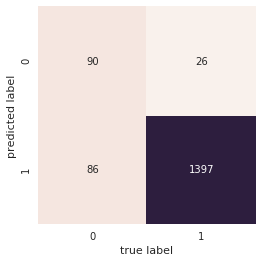

In [117]:
#Evaluating
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))

#evaluating
print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))
print(f1_score(ytest, ypred))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


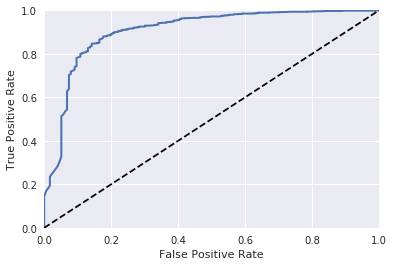

0.905625119785


In [118]:
#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

y_probas_forest = cross_val_predict(model, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_forest = y_probas_forest[:, 1]   # score = proba of positive class 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(ytest, y_scores_forest)

def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_forest, tpr_forest) 
plt.show()
print(roc_auc_score(ytest, y_scores_forest))

Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.174521)
2. feature 2 [MatemticaI120H] (0.106843)
3. feature 1 [LnguaPortuguesaeLiteraturaII90H] (0.056370)
4. feature 3 [MatemticaII90H] (0.048377)
5. feature 7 [renda_bruta_familiar] (0.046233)
6. feature 5 [ano_letivo__ano_matricula_periodo] (0.034515)
7. feature 6 [qtd_pessoas_domicilio] (0.026224)
8. feature 4 [ano_letivo__ano] (0.024134)
9. feature 10 [descricao_area_residencial_Não informado] (0.016279)
10. feature 12 [descricao_area_residencial_Urbana] (0.009996)
11. feature 151 [sigla_MC] (0.009672)
12. feature 101 [descricao_raca_Branca] (0.009639)
13. feature 104 [descricao_raca_Parda] (0.008815)
14. feature 41 [descricao_historico_Técnico de Nivel Médio em Informática] (0.008641)
15. feature 140 [pessoa_fisica__sexo_M] (0.008628)
16. feature 139 [pessoa_fisica__sexo_F] (0.008479)
17. feature 77 [descricao_imovel_Próprio] (0.008340)
18. feature 18 [descricao_companhia_domiciliar_Pais] (0.008181)
19. feature 124

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


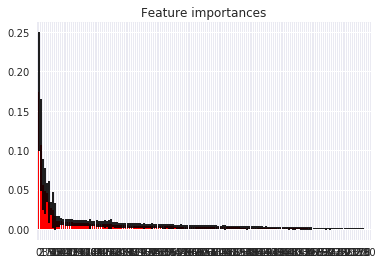

In [119]:
#FEATURES IMPORTANCE
"""
cont = 0
for name, score in zip(dados_clean.columns, model.feature_importances_):     
    print(name, score) 
    if cont > 10:
        break
    cont = cont + 1
"""

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtest.shape[1]):
    print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], dados_clean.columns[indices[f]],importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(Xtest.shape[1]), indices)
plt.xlim([-1, Xtest.shape[1]])
plt.show()

In [ ]:
#FIM RANDOM FOREST

In [48]:
#DECISION TREE
#Xtrain, Xtest, ytrain, ytest = train_test_split(dados_clean, y, random_state=0)
tree_clf = DecisionTreeClassifier(max_depth=3) 
tree_clf.fit(Xtrain, ytrain)
ypred = tree_clf.predict(Xtest)



0.915572232645
0.947222222222
0.958538299368
0.952846664338


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


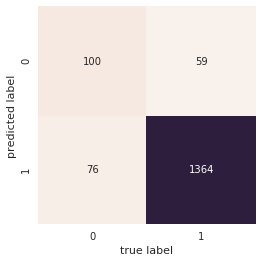

In [49]:
#porcentagem de predicao correta
n_correct = sum(ypred == ytest)    
print(n_correct / len(ypred)) 

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

#evaluating
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#evaluating
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

print(precision_score(ytest, ypred))
print(recall_score(ytest, ypred))
print(f1_score(ytest, ypred))

In [50]:
from sklearn.tree import export_graphviz

export_graphviz(tree_clf,
                feature_names=dados_clean.columns,
                filled=True,
                rounded=True, 
                out_file='tree.dot')

import os
os.system('dot -Tpng tree.dot -o tree.png')

0

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


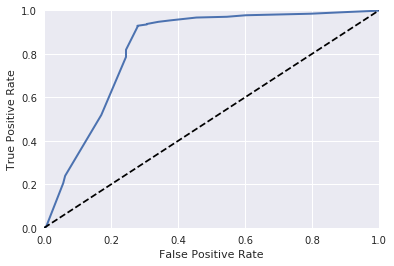

0.828557225452


In [51]:
y_probas_tree = cross_val_predict(tree_clf, Xtest, ytest, cv=3, method="predict_proba") 

y_scores_tree = y_probas_tree[:, 1]   # score = proba of positive class 
fpr_tree, tpr_tree, thresholds_tree = roc_curve(ytest, y_scores_tree)

def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr_tree, tpr_tree) 
plt.show()
print(roc_auc_score(ytest, y_scores_tree))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


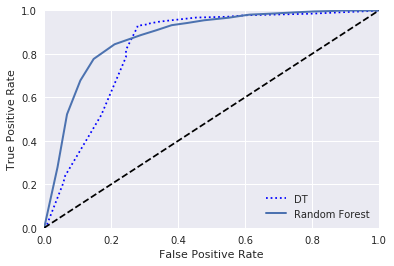

In [52]:
#PLOTAR DUAS CURVAS ROC (DT e RF)
plt.plot(fpr_tree, tpr_tree, "b:", label="DT") 
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 
plt.legend(loc="bottom right") 
plt.show()